**Customer segmentation**

Is the practice of separating customers into groups that reflect similarities among customers in each cluster. I will divide customers into segments to optimize the significance of each customer to the business. To modify products according to distinct needs and behaviours of the customers. It also helps the business to cater to the concerns of different types of customers.

# Import Necessary Libraries and the dataset

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#datasetslink=datasets link https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

In [115]:
data = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [116]:
data.shape

(541909, 8)

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [118]:
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

# Overview and Cleaning the Data

In [119]:
# Check for nulls in train_df
for i in data.columns:
    null_ratio = data[i].isna().sum() / len(data) * 100
    if null_ratio > 0 :
        print("{} null ratio: {}%".format(i,round(null_ratio,2)))

Description null ratio: 0.27%
CustomerID null ratio: 24.93%


In [120]:
data = data.dropna()
data.shape

(406829, 8)

In [121]:
data.duplicated().count()

406829

In [122]:
data.dropna(inplace=True)

In [123]:
# counts of the negative values in the Quantity
data[data['Quantity'] <0].shape[0]

8905

In [124]:
data[data.Quantity < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom


In [125]:
data['cancellation'] = data.InvoiceNo.str.extract('([C])').fillna(0).replace({'C':1})
data.cancellation.value_counts()

0    397924
1      8905
Name: cancellation, dtype: int64

In [126]:
data[data.cancellation == 1]['CustomerID'].nunique() / data.CustomerID.nunique() * 100

36.34492223238792

In [127]:
data[data.cancellation == 1]['CustomerID'].value_counts(dropna = False).head(5)

14911.0    226
17841.0    136
17511.0    113
15311.0    112
12607.0    101
Name: CustomerID, dtype: int64

In [128]:
data = data[data.CustomerID.notnull()]

In [129]:
data = data[(data.Quantity > 0) & (data.UnitPrice > 0)]

In [130]:
data[data.cancellation == 1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancellation


In [131]:
data = data.drop('cancellation', axis = 1)

In [132]:
# Changing the datatype of Customer Id as per Business understanding

data['CustomerID'] = data['CustomerID'].astype(str)

In [133]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [134]:
print(data["Quantity"].min())
print(data["UnitPrice"].min())

1
0.001


In [135]:
# creating a new column of Total amount
data["TotalPrice"]=data["Quantity"]*data["UnitPrice"]

In [136]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


R (Recency): Number of days since last purchase

F (Frequency): Number of tracsactions

M (Monetary): Total amount of transactions (revenue contributed)

In [137]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [138]:
# a point of reference date

ref_date = max(data['InvoiceDate'])
ref_date

Timestamp('2011-12-10 17:19:00')

In [139]:
data['Date']=data['InvoiceDate'].apply(lambda x: x.date())
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-01-12
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-01-12


In [140]:
data['Last_Purchase_Date']=data.groupby(['CustomerID'])['Date'].transform(max)
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date,Last_Purchase_Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-01-12,2010-02-12
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-01-12,2010-02-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12


In [141]:
data['Recency']=data.groupby('CustomerID')['Last_Purchase_Date'].apply(lambda x:ref_date.date() - x)
data['Recency']=data.agg({'Recency':lambda x:x.astype('timedelta64[D]')})

data.head()

<ipython-input-141-791eb029be4a>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['Recency']=data.groupby('CustomerID')['Last_Purchase_Date'].apply(lambda x:ref_date.date() - x)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date,Last_Purchase_Date,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-01-12,2010-02-12,666.0
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12,666.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-01-12,2010-02-12,666.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12,666.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01-12,2010-02-12,666.0


In [142]:
#Drop Last_Purchase_Date since we don't need it anymore
data = data.drop('Last_Purchase_Date',axis=1)

In [143]:
data['Frequency'] = data.groupby('CustomerID').InvoiceNo.transform('nunique')

In [144]:
data['Monetary'] = data.groupby('CustomerID').TotalPrice.transform('sum')

In [145]:
RFM = data[['CustomerID','Recency','Frequency','Monetary']].drop_duplicates()
RFM.sort_index()

,CustomerID,Recency,Frequency,Monetary
0,17850.0,666.0,34,5391.21
9,13047.0,57.0,10,3237.54
26,12583.0,0.0,15,7281.38
46,13748.0,159.0,5,948.25
65,15100.0,70.0,3,876.00
...,...,...,...,...
536969,13436.0,120.0,1,196.89
537255,15520.0,120.0,1,343.50
538064,13298.0,120.0,1,360.00
538812,14569.0,120.0,1,227.39


In [146]:
RFM.shape

(4338, 4)

# Outliers detection

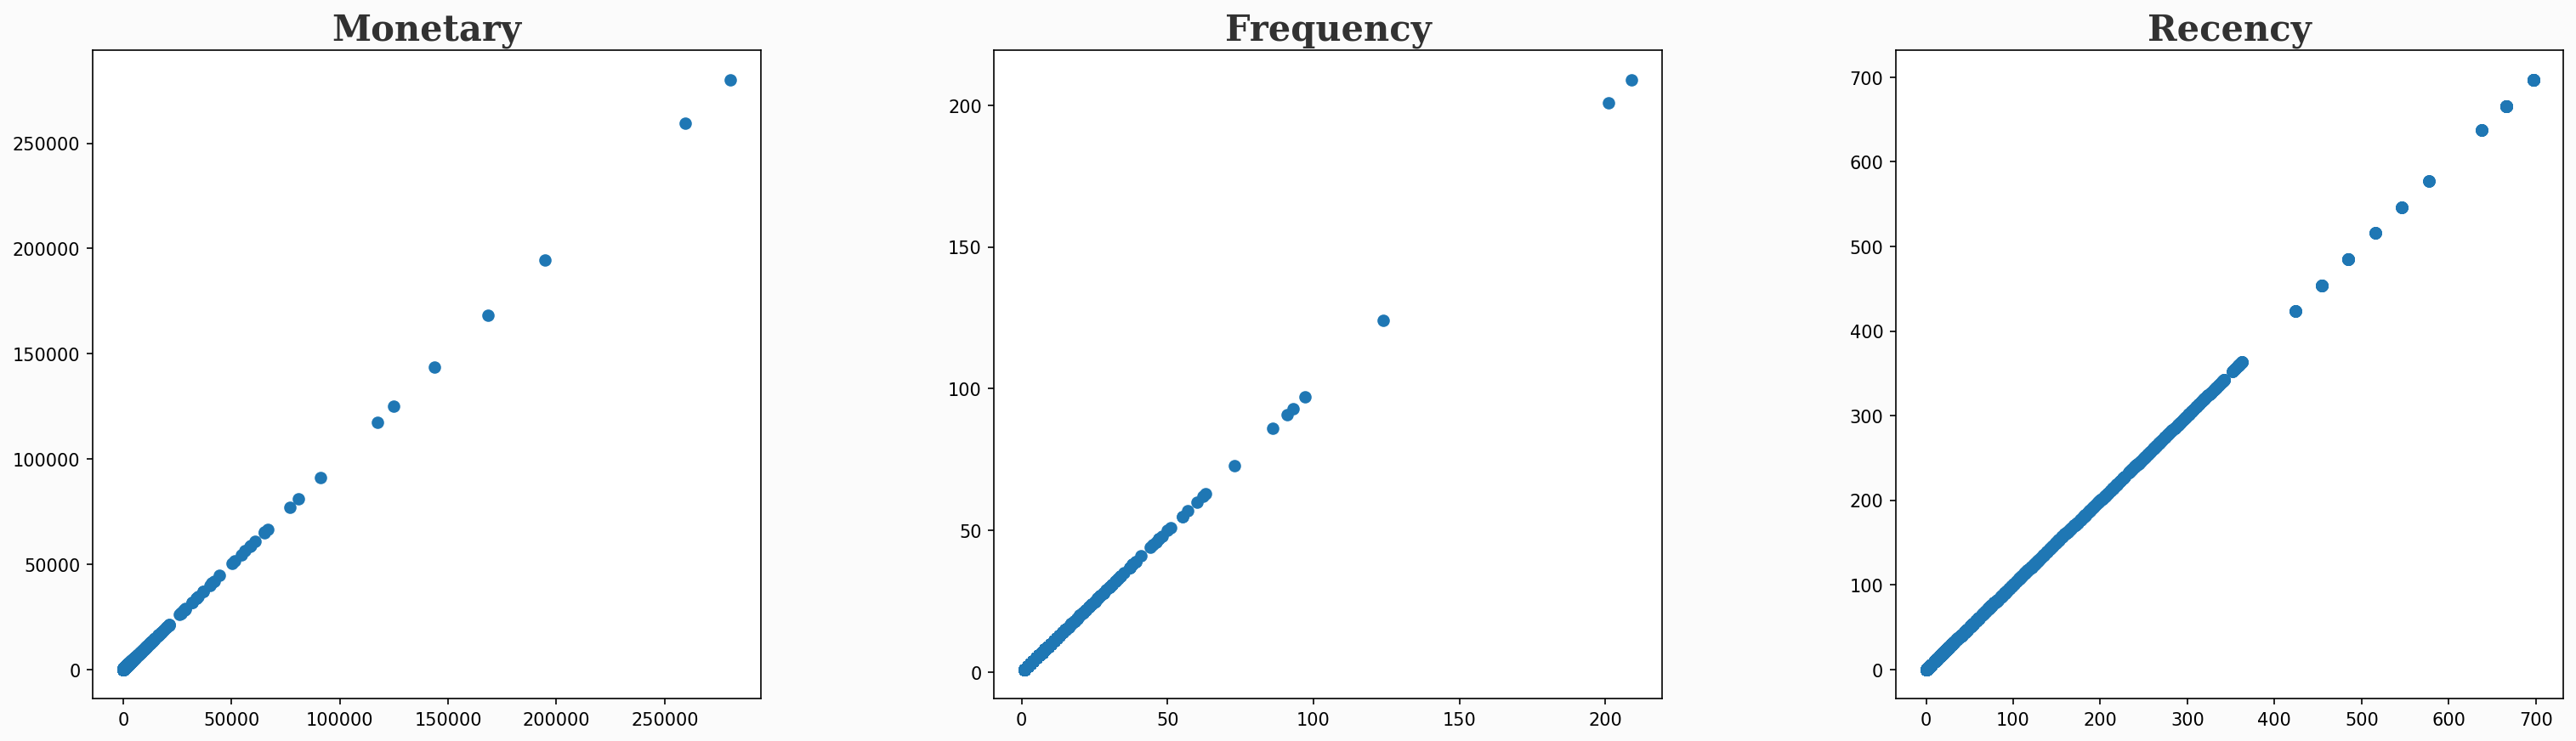

In [147]:
background_color = "#fbfbfb"

fig = plt.figure(figsize=(25,15),dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])


# ax0 Amount
#y=df['Amount'].value_counts()

ax0.scatter(RFM['Monetary'], RFM['Monetary'])
ax0.set_title("Monetary", fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")


# ax0 Frequency
ax1.scatter(RFM['Frequency'], RFM['Frequency'])
ax1.set_title("Frequency", fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")



# ax0 Recency
ax2.scatter(RFM['Recency'], RFM['Recency'])
ax2.set_title("Recency", fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")


plt.show()

In [149]:
# Removing (statistical) outliers for Amount
Q1 = RFM.Monetary.quantile(0.05)
Q3 = RFM.Monetary.quantile(0.95)
IQR = Q3 - Q1
RFM = RFM[(RFM.Monetary >= Q1 - 1.5*IQR) & (RFM.Monetary <= Q3 + 1.5*IQR)]

In [150]:
# Removing (statistical) outliers for Recency
Q1 = RFM.Recency.quantile(0.05)
Q3 = RFM.Recency.quantile(0.95)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [151]:
# Removing (statistical) outliers for Frequency
Q1 = RFM.Frequency.quantile(0.05)
Q3 = RFM.Frequency.quantile(0.95)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

In [152]:

RFM_df = RFM[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()
# fit_transform
RFM_scaled = scaler.fit_transform(RFM_df)
RFM_scaled.shape

(4261, 3)

In [156]:
RFM_scaled = pd.DataFrame(RFM_scaled)
RFM_scaled.columns = ['Monetary', 'Frequency', 'Recency']
RFM_scaled.head()

,Monetary,Frequency,Recency
0,1.056632,1.648057,-0.433462
1,3.289469,2.942503,-0.928696
2,-0.207417,0.353611,0.452747
3,-0.247310,-0.164168,-0.320514
4,1.846637,2.942503,-0.893943


# Segmentation by K-Mean Clustering Algorithm

Find the optimal number of clusters

In [ ]:
inertia = []
num_clusters = list(range(1,10))

for k in num_clusters:
    #Instantiate model in range k
    kmeans = KMeans(n_clusters = k)
    #fit model
    kmeans.fit(RFM_scaled)
    #append the SSE in k cluster to the list
    inertia.append(kmeans.inertia_)

In [ ]:
cost_kneed = KneeLocator(x = num_clusters , y = inertia , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
K_cost_c3 = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(K_cost_c3))

Elbow at k = 3 clusters


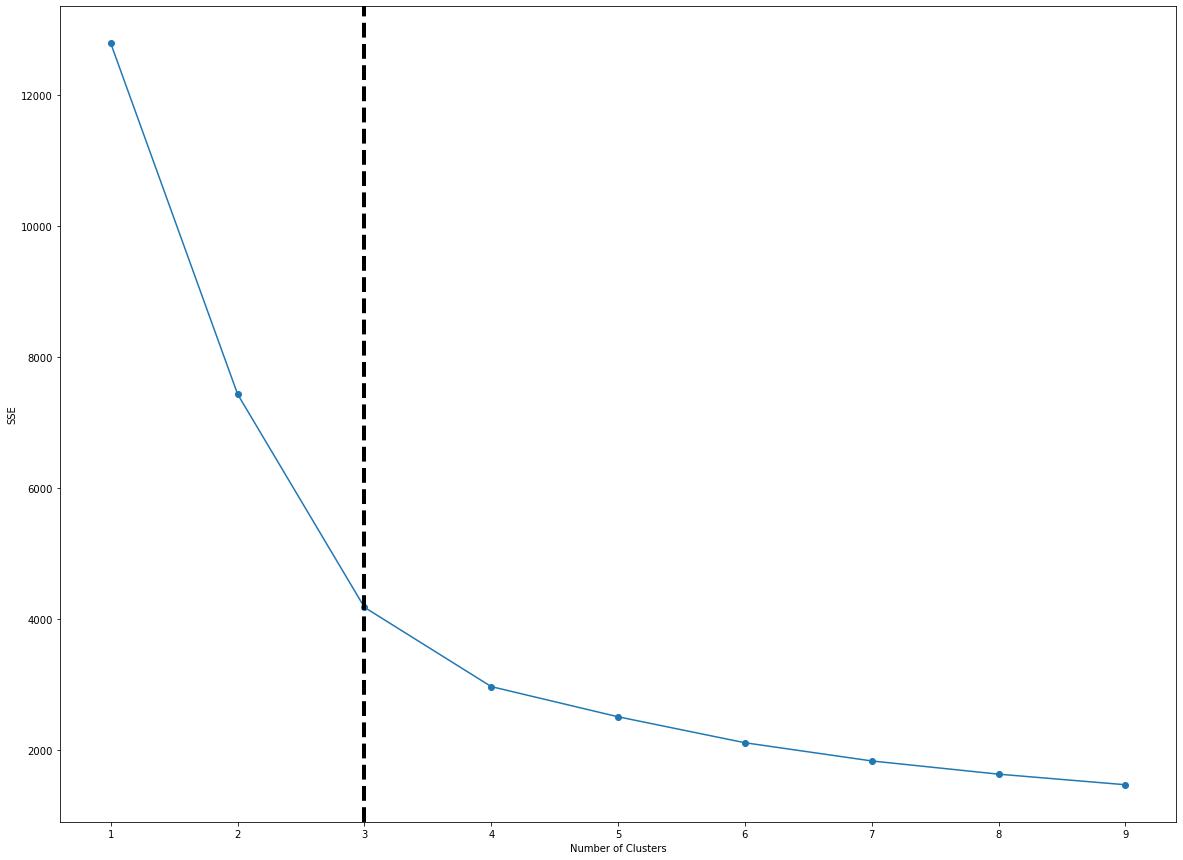

In [ ]:
#Plot the graph
plt.figure(figsize=(20,15))
plt.plot(num_clusters , inertia , 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
#plot vertical line at the elbow spot
plt.axvline(x=K_cost_c3, color='black', label='axvline-fullheight', ls='--', linewidth=4)

In [ ]:
model = KMeans(n_clusters = 3)
model.fit(RFM_scaled)

KMeans(n_clusters=3)

In [ ]:
model.labels_

array([0, 0, 2, ..., 2, 2, 2], dtype=int32)

In [ ]:
#assign cluster in unscaled data set
RFM_scaled['cluster'] = model.labels_
# +1 cluster
RFM_scaled['cluster'] = RFM_scaled['cluster'].apply(lambda x : x+1)

In [ ]:
RFM_scaled.head()

,Monetary,Frequency,Recency,cluster
0,1.056632,1.648057,-0.622830,1
1,3.289469,2.942503,-0.912588,1
2,-0.207417,0.353611,0.016635,3
3,-0.247310,-0.164168,2.394646,2
4,1.846637,2.942503,-0.682780,1


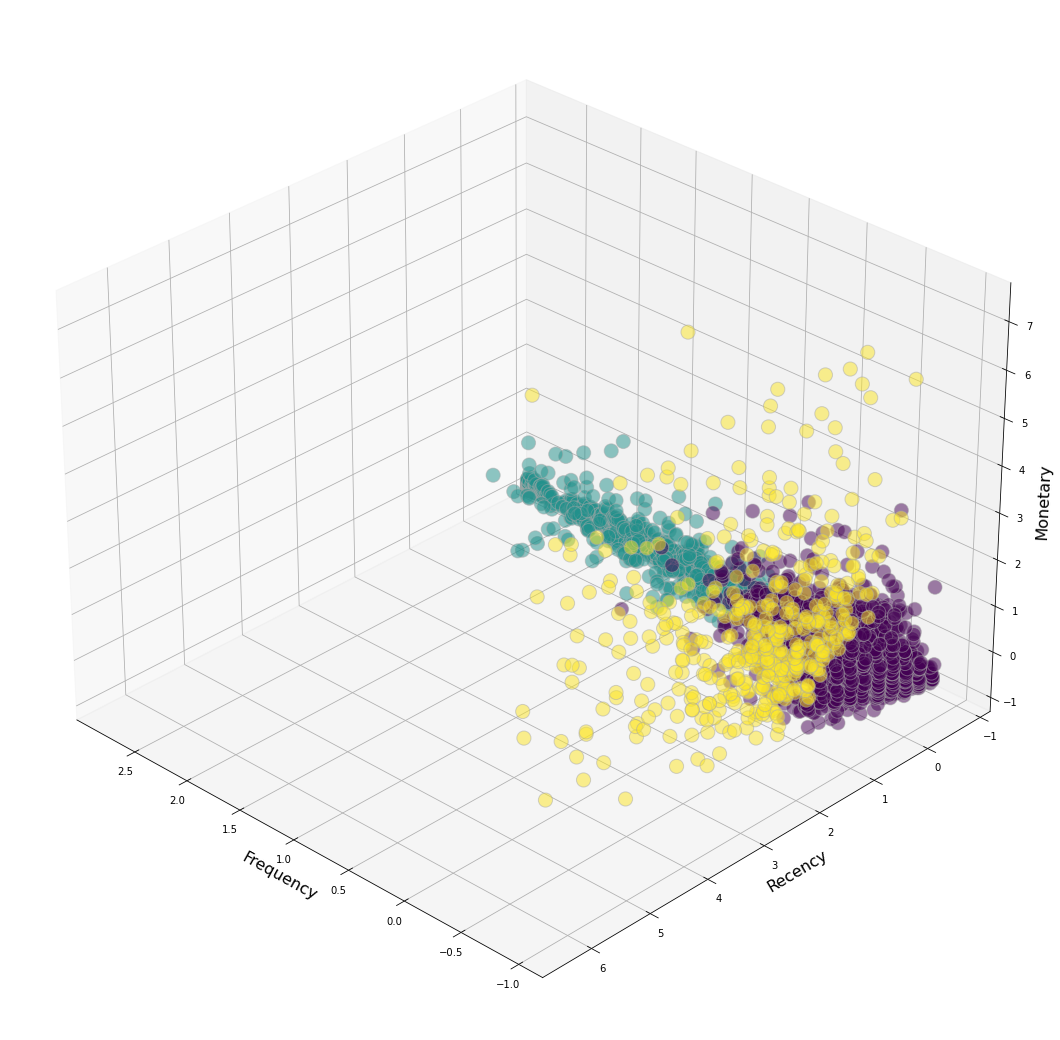

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize']= (15,15)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig,
          rect = [0,0, .95, 1],
          azim = 134)
plt.cla()
ax.scatter(RFM_scaled['Recency'], RFM_scaled['Frequency'], RFM_scaled['Monetary'],
           c = RFM_scaled['cluster'],
           s = 200 ,
           alpha = 0.5,
           edgecolor= 'darkgrey')

ax.set_xlabel('Frequency', fontsize= 16)

ax.set_ylabel('Recency', fontsize= 16)

ax.set_zlabel('Monetary', fontsize= 16)

plt.show()